In [1]:
from pathlib import Path 
import pandas as pd
from datetime import datetime, timedelta

class MRMSDataLoader: 
    
    MRMS_PATH = '/work/rt_obs/MRMS/RAD_AZS_MSH/'
    
    def __init__(self, case_date, datetime_rng):
        self.case_date = case_date
        self.datetime_rng = datetime_rng 

    def find_mrms_files(self):
        """
        When given a start and end date, this function will find any MRMS RAD 
        files between those time periods. It will check if the path exists. 
        """
        year = str(self.datetime_rng[0].year) 
        mrms_filenames = [date.strftime('wofs_MRMS_RAD_%Y%m%d_%H%M.nc') for date in self.datetime_rng]

        mrms_filepaths = [Path(self.MRMS_PATH).joinpath(year, self.case_date, f) 
                          if Path(self.MRMS_PATH).joinpath(year, self.case_date, f).is_file() else None
                          for f in mrms_filenames 
                 ]
       
        return mrms_filepaths 
    
    def resize(self, ds, n_lat=300, n_lon=300, domain_size=150):
        """Resize the domain"""
        start_lat, start_lon = (n_lat - domain_size) // 2, (n_lon - domain_size) // 2
        end_lat, end_lon = start_lat + domain_size, start_lon + domain_size
        
        # Subsetting the dataset to the central size x size grid
        ds_subset = ds.isel(lat=slice(start_lat, end_lat), lon=slice(start_lon, end_lon))
        
        return ds_subset
    
    def load(self):
        
        domain_size = 150
        n_lat, n_lon = 300,300

        files = self.find_mrms_files()
        
        # Initialize an empty list to store the datasets with 'mesh_consv' variable
        data = np.zeros((len(files), domain_size, domain_size))

        # Load 'mesh_consv' variable from each file and append to the datasets list
        for t, file in enumerate(files):
            if file is not None: 
                ds = xr.open_dataset(file, drop_variables=['lat', 'lon'])
                
                start_lat, start_lon = (n_lat - domain_size) // 2, (n_lon - domain_size) // 2
                end_lat, end_lon = start_lat + domain_size, start_lon + domain_size
                
                # Resize the output to 150 x 150
                #ds = self.resize(ds)
                
                data[t,:,:] = ds['dz_consv'].values[start_lat:end_lat, start_lon:end_lon]
    
                ds.close()
        

        return data

def get_case_date(path):
    name = os.path.basename(path)
    comps = name.split('_')
    
    start_date = comps[1]+'_'+comps[2]
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d_%H%M%S')
    
    if start_date_dt.hour < 14:
        case_date = start_date_dt.date() - timedelta(days=1)
    else:
        case_date = start_date_dt.date() 
        
    return case_date.strftime('%Y%m%d')

def to_datetimes(path, n_times = 13):  
    name, freq, ens_mem = os.path.basename(path).split('__')
    start_time_dt = datetime.strptime(name.split('_to')[0], 'wrfwof_%Y-%m-%d_%H%M%S')
    start_time = pd.Timestamp(start_time_dt)
    
    dt_list = pd.date_range(start=start_time, periods=n_times, freq=freq)
    
    # Remove the first 2 time steps, since those aren't plotted 
    # as they are used as the initial input. 
    return dt_list[2:]

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from wofscast.model import WoFSCastModel
from wofscast.border_mask import BORDER_MASK_NUMPY

from wofscast.data_generator import (load_chunk, 
                                     WRFZarrFileProcessor,
                                     WoFSDataProcessor, 
                                     dataset_to_input,
                                     ZarrDataGenerator,
                                     add_local_solar_time,
                                    )
from wofscast import checkpoint
from wofscast.wofscast_task_config import (DBZ_TASK_CONFIG, 
                                           WOFS_TASK_CONFIG, 
                                           DBZ_TASK_CONFIG_1HR,
                                           DBZ_TASK_CONFIG_FULL
                                          )

from wofscast.model_utils import dataset_to_stacked, variable_to_stacked
from wofscast.normalization import normalize 

import os
from os.path import join
from concurrent.futures import ThreadPoolExecutor
import random
import numpy as np
import xarray as xr
from tqdm.notebook  import tqdm 

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import time 

from typing import Optional, Mapping, Tuple, List

def get_files_for_year(year):
    """Get all zarr files within a directory."""
    year_path = join(base_path, year)
    with os.scandir(year_path) as it:
        return [join(year_path, entry.name) for entry in it if entry.is_dir() and entry.name.endswith('.zarr')] 

def get_random_subset(input_list, subset_size, seed=123):
    """
    Get a random subset of a specified size from the input list.

    Parameters:
    -----------
    input_list : list
        The original list from which to draw the subset.
    subset_size : int
        The size of the subset to be drawn.
    seed : int, optional
        The seed for the random number generator. Default is None.

    Returns:
    --------
    list
        A random subset of the input list.
    """
    if subset_size > len(input_list):
        raise ValueError("subset_size must be less than or equal to the length of the input list")
    
    if seed is not None:
        random.seed(seed)

    return random.sample(input_list, subset_size)

task_config = WOFS_TASK_CONFIG

#base_path = '/work/mflora/wofs-cast-data/datasets_zarr/'

base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/'

    
# Corey's best model so far. 
MODEL_PATH = '/work/cpotvin/WOFSCAST/model/wofscast_test_v203.npz'
norm_stats_path = '/work/mflora/wofs-cast-data/full_normalization_stats'
    
model = WoFSCastModel(norm_stats_path = norm_stats_path)
model.load_model(MODEL_PATH)
    
years = ['2019', '2020']
with ThreadPoolExecutor() as executor:
    paths = []
    for files in executor.map(get_files_for_year, years):
        paths.extend(files)
    
n_batches = 24 #10000
paths = get_random_subset(paths, n_batches, seed=42)

from tdigest import TDigest

# Initialize a t-digest object
target_digest = TDigest(delta=0.01)

#for path in tqdm(paths): 
dataset = load_chunk(paths, 1, add_local_solar_time)
dataset = dataset.compute() 
        
inputs, targets, forcings = dataset_to_input(dataset, task_config, 
                                            target_lead_times=slice('10min', '120min'))
predictions = model.predict(inputs, targets, forcings)

In [14]:
%%time
dbz_target = targets['COMPOSITE_REFL_10CM'].isel(time=[0]).squeeze().values[::2, ::2].flatten()

predict_digests = [TDigest(delta=0.001) for _ in range(predictions.dims['time'])]

for t in range(predictions.dims['time']):
    dbz_predict = predictions['COMPOSITE_REFL_10CM'].isel(time=t).squeeze().values[::2, ::2].flatten()
    predict_digests[t].batch_update(dbz_predict)
    
# Add data points to the t-digest
target_digest.batch_update(dbz_target)
mrms_digest = TDigest(delta=0.001)

for path in paths:
    # Load the MRMS data and compute object verification statistics 
    # against both the WoFS and MRMS. 
    case_date = get_case_date(path)
    dts = to_datetimes(path, n_times = len(predictions.time)+2)
    loader = MRMSDataLoader(case_date, dts[:2])
    mrms_ds = loader.load().flatten()
    
    mrms_digest.batch_update(mrms_ds)

CPU times: user 1min 29s, sys: 245 ms, total: 1min 30s
Wall time: 1min 30s


In [15]:
predict_digests

[<T-Digest: n=135000, centroids=3096>,
 <T-Digest: n=135000, centroids=5317>,
 <T-Digest: n=135000, centroids=6129>,
 <T-Digest: n=135000, centroids=6217>,
 <T-Digest: n=135000, centroids=5869>,
 <T-Digest: n=135000, centroids=6041>,
 <T-Digest: n=135000, centroids=5904>,
 <T-Digest: n=135000, centroids=6129>,
 <T-Digest: n=135000, centroids=6027>,
 <T-Digest: n=135000, centroids=5941>,
 <T-Digest: n=135000, centroids=5697>,
 <T-Digest: n=135000, centroids=5404>]

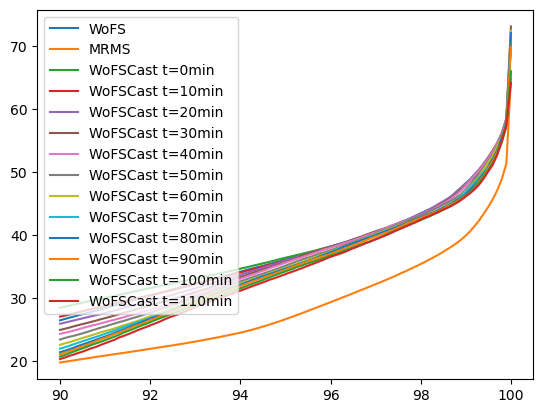

In [16]:
import matplotlib.pyplot as plt

percentiles = np.linspace(90, 99.9999, 100)
data = {'WoFS' : target_digest, 
        #'WoFSCast' : predict_digest, 
        'MRMS' : mrms_digest
       }

for key in data.keys():
    vals = [data[key].percentile(n) for n in percentiles]
    plt.plot(percentiles, vals, label=key)
    
for t in range(len(predict_digests)):
    vals = [predict_digests[t].percentile(n) for n in percentiles]
    plt.plot(percentiles, vals, label=f'WoFSCast t={t*10}min')
    
plt.legend()

Closest percentile to 40 in MRMS is 98.98980909090909 with value 39.865781064236955
Value at percentile 98.98980909090909 for WoFS is 47.860539799220675
Value at percentile 98.98980909090909 for WoFSCast t=0min is 48.200867978109734
Value at percentile 98.98980909090909 for WoFSCast t=10min is 47.89085069280685
Value at percentile 98.98980909090909 for WoFSCast t=20min is 48.16867842448845
Value at percentile 98.98980909090909 for WoFSCast t=30min is 47.82478822002169
Value at percentile 98.98980909090909 for WoFSCast t=40min is 47.833543873989264
Value at percentile 98.98980909090909 for WoFSCast t=50min is 47.20548976074568
Value at percentile 98.98980909090909 for WoFSCast t=60min is 46.958937380049
Value at percentile 98.98980909090909 for WoFSCast t=70min is 46.74359237699803
Value at percentile 98.98980909090909 for WoFSCast t=80min is 46.44459291969648
Value at percentile 98.98980909090909 for WoFSCast t=90min is 46.27775191064316
Value at percentile 98.98980909090909 for WoFSCa

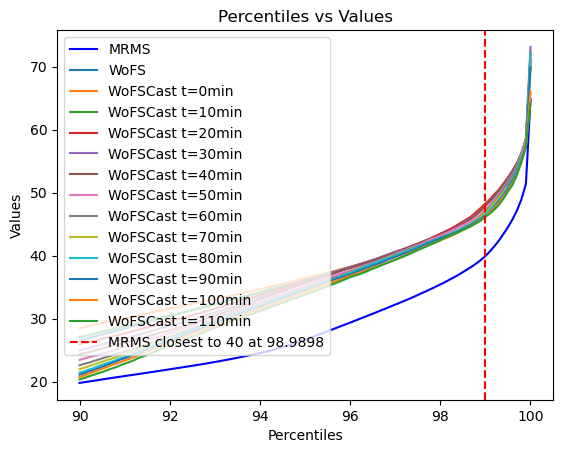

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming percentiles and data dictionaries are already defined
percentiles = np.linspace(90, 99.9999, 100)
data = {'WoFS': target_digest,
        'MRMS': mrms_digest
       }

# Function to find the percentile closest to a specific value
def find_closest_percentile(vals, percentiles, target_value):
    differences = [abs(val - target_value) for val in vals]
    min_diff_index = np.argmin(differences)
    return percentiles[min_diff_index], vals[min_diff_index]

# Find the closest percentile to 40 in MRMS
vals_mrms = [data['MRMS'].percentile(n) for n in percentiles]
closest_percentile_mrms, closest_value_mrms = find_closest_percentile(vals_mrms, percentiles, 40)

print(f"Closest percentile to 40 in MRMS is {closest_percentile_mrms} with value {closest_value_mrms}")

# Find the value of other datasets at this percentile
corresponding_values = {}
for key in data.keys():
    if key != 'MRMS':
        value_at_percentile = data[key].percentile(closest_percentile_mrms)
        corresponding_values[key] = value_at_percentile
        print(f"Value at percentile {closest_percentile_mrms} for {key} is {value_at_percentile}")

# For WoFSCast data
for t in range(len(predict_digests)):
    value_at_percentile = predict_digests[t].percentile(closest_percentile_mrms)
    corresponding_values[f'WoFSCast t={t*10}min'] = value_at_percentile
    print(f"Value at percentile {closest_percentile_mrms} for WoFSCast t={t*10}min is {value_at_percentile}")

# Optional: Plotting the results
plt.plot(percentiles, vals_mrms, label='MRMS', color='blue')
for key in corresponding_values.keys():
    vals = [data[key].percentile(n) for n in percentiles] if 'WoFSCast' not in key else [predict_digests[int(key.split('=')[1].split('min')[0])//10].percentile(n) for n in percentiles]
    plt.plot(percentiles, vals, label=key)

plt.axvline(closest_percentile_mrms, color='red', linestyle='--', label=f'MRMS closest to 40 at {closest_percentile_mrms:.4f}')
plt.legend()
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.title('Percentiles vs Values')
plt.show()
